In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils import *

In [36]:
N = 1000
def data_gen(moons=True):
    all_data = []
    if not moons:
        for i in range(N):
            r1 = np.random.rand(1)
            r2 = np.random.rand(1)
            if r1 < r2:
                label = 0
            # if r1 ** 2 < r2:
            #     label = 0
            else:
                label = 1
            all_data.append([torch.tensor([r1, r2]), label])
            return all_data
    else:
        X,y = datasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=1234)
        y = np.reshape(y, (len(y),1))
        for index, point in enumerate(X):
            point=np.reshape(point, (2,1))
            all_data.append([torch.tensor(point), y[index][0]])
        return all_data

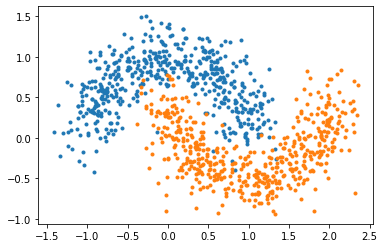

In [37]:
all_data = data_gen()

zeros_x = [all_data[i][0][0] for i in range(N) if not all_data[i][1]]
zeros_y = [all_data[i][0][1] for i in range(N) if not all_data[i][1]]

ones_x = [all_data[i][0][0] for i in range(N) if all_data[i][1]]
ones_y = [all_data[i][0][1] for i in range(N) if all_data[i][1]]

plt.plot(zeros_x, zeros_y, '.')
plt.plot(ones_x, ones_y, '.')

plt.show()

In [38]:
train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [39]:
# output1 = 10

# model = nn.Sequential(
#     nn.Linear(2, output1),
#     nn.ReLU(),
#     nn.Linear(output1, 1)
# )

In [40]:
from tqdm.notebook import tqdm, trange
# torch.random.manual_seed(1572022)

output1 = 10
output2 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    # nn.Linear(output1, output2),
    # nn.ReLU(),
    nn.Linear(output1, 1)
)

epochs = 1000
num_of_params = get_n_params(model)
C_tracking = True


optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

effective_ranks = []
losses = []
C_matrices = []

for epoch in trange(epochs):
    row_counter = 0
    tensor = torch.zeros((len(train_loader),num_of_params))
    avg_loss = 0
    for points, labels in train_loader:
        # print(points.shape)
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        # print(x.shape)
        labels = labels[:,None].double()
        # print(x)
        y = model(x)
        loss = criterion(y, labels)
        avg_loss += loss
        
        loss.backward()
        optimizer.step()

        tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
        row_counter += 1
    effective_ranks.append(effective_rank(tensor))
    losses.append(avg_loss/len(train_loader))
    if C_tracking:
        C_matrix = tensor @ tensor.T
        # C_diags = torch.sqrt(torch.outer(tensor.diagonal(), tensor.diagonal()))
        C_matrices.append(C_matrix)
    

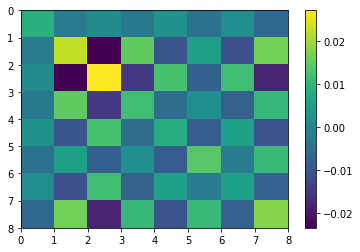

In [41]:
plt.pcolor(C_matrices[-1].detach().numpy())
plt.colorbar()
plt.gca().invert_yaxis()

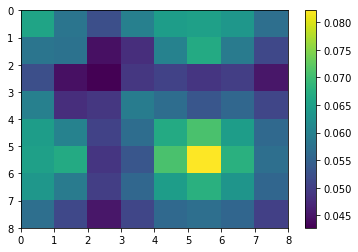

In [42]:
C = C_matrices[0].numpy()
A = (C>0.0)*1.0
from scipy.linalg import eigh
U, V = eigh(np.diag(A.sum(1)) - A)
v = V[:,1]
indices = np.argsort(v)
plt.pcolor(C[indices, :][:, indices])
plt.colorbar()
plt.gca().invert_yaxis()

In [43]:
U[1]

7.999999999999996

(-0.01, 0.05)

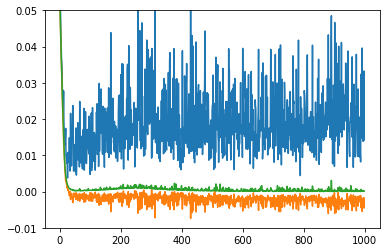

In [44]:
diag_means = [c.diag().mean().numpy() for c in C_matrices]
plt.plot(diag_means)
N= C_matrices[0].shape[0]
non_diag_means = [(c.sum() - c.diag().sum().numpy()) / (N**2-N) for c in C_matrices]
plt.plot(non_diag_means)
average = [c.mean() for c in C_matrices]
plt.plot(average)

plt.ylim([-0.01,0.05])

In [45]:
# if C_tracking:
#     C_matrices[-1]
#     negatives = []
#     for C in C_matrices:
#         for col_ind, col in enumerate(C):
#             for row_ind, item in enumerate(col):
#                 if row_ind != col_ind and item < 0:
#                     negatives.append(item)
#     print("Negatives:", len(negatives))
#     print("Positives: ", 40**2-40-len(negatives))


Text(0, 0.5, 'Effective rank')

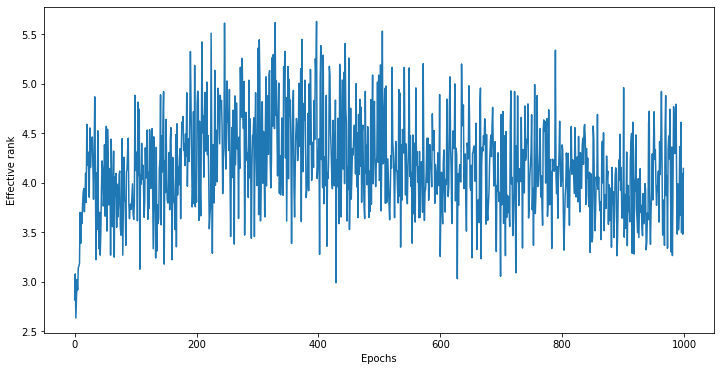

In [46]:
from matplotlib.pyplot import figure

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)

plt.plot(effective_ranks, '-')
plt.xlabel("Epochs")
plt.ylabel("Effective rank")

# arr = np.tanh(np.array(range(-epochs//2, epochs - epochs//2))/50) + 5.6 * np.ones(1000)
# plt.plot(arr)


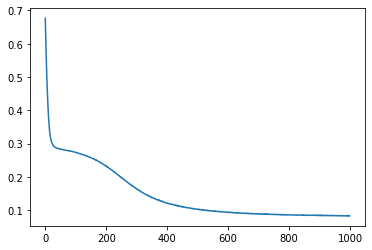

In [47]:
plt.plot(losses)

In [48]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            # print(predictions2)
            # print(labels2)
            correct_test += torch.sum((predictions2 == labels2).float())
            # print(correct_test)
print(f'Test accuracy: {correct_test/len(test_data)}')


Test accuracy: 0.9649999737739563


In [49]:
# train_data = all_data[:N*8//10]
# test_data = all_data[N*8//10:]
# batch_size = 20
# items = np.zeros(150)

# def optimize():
#     train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
#     test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

#     epochs = 150
#     num_of_params = get_n_params(model)
#     C_tracking = False


#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#     criterion = nn.BCEWithLogitsLoss()

#     effective_ranks = []

#     for epoch in trange(epochs):
#         row_counter = 0
#         tensor = torch.zeros((len(train_loader),num_of_params))
#         C_matrices = []
#         for points, labels in train_loader:
            
#             optimizer.zero_grad()

#             x = points[:,:,0].float()
#             # print(x.shape)
#             labels = labels[:,None].double()

#             y = model(x)
#             loss = criterion(y, labels)
            
#             loss.backward()
#             optimizer.step()

#             tensor[row_counter, :] = flatten_and_together([param.grad for param in list(model.parameters())])
#             row_counter += 1
#         if C_tracking:
#             C_matrix = tensor @ tensor.T
#             C_diags = np.sqrt(np.outer(tensor.diagonal(), tensor.diagonal()))
#             C_matrices.append(C_matrix)
#         effective_ranks.append(effective_rank(tensor))
#     return effective_ranks

# # for i in range(10):
# #     items += optimize()
# # meanarray = np.array(items) / 10

In [50]:
# f = plt.figure()
# f.set_figwidth(12)
# f.set_figheight(6)

# plt.plot(meanarray, '.-')
# plt.xlabel("Epochs")
# plt.ylabel("Effective rank")

# # print(items)